# Week 9-1: Unsupervised Machine Learning

## Bibliotheken importeren

In [2]:
import pandas as pd
from sklearn.cluster import KMeans
import math
import matplotlib.pyplot as plt
import warnings
import numpy as np
import pyodbc
warnings.simplefilter('ignore')
from sklearn.metrics.pairwise import euclidean_distances

## Data inlezen en kolommen selecteren

In [4]:
DB_SDM = {"servername": r"localhost,1433", "database": "sdm", "username": "sa", "password": "iDTyjZx7dRL4"}

sdm_conn = pyodbc.connect(
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER={DB_SDM['servername']};"
    f"DATABASE={DB_SDM['database']};"
    f"UID={DB_SDM['username']};"
    f"PWD={DB_SDM['password']}"
)

In [6]:
def create_dataframes_sql(connection):
    dictionary : dict = {}
    query : str = ""
    key : str = ""

    query = "SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE = 'BASE TABLE';"
    key = "TABLE_NAME"

    table_names = pd.read_sql(query, connection)

    for table in table_names[key].tolist():
        dictionary[table] = pd.read_sql(f"SELECT * FROM {table}", connection)

    return dictionary

sdm = create_dataframes_sql(sdm_conn)

print(list(sdm.keys()))

['sales_territory', 'country', 'order_method', 'retailer_site', 'sales_branch', 'sales_staff', 'retailer_contact', 'order_header', 'product_line', 'product_type', 'product', 'order_details', 'return_reason', 'returned_item', 'course', 'satisfaction_type', 'satisfaction', 'training', 'age_group', 'retailer_segment', 'retailer_headquarters', 'retailer_type', 'retailer', 'sales_demographic', 'inventory_levels', 'forecast']


In [7]:
sales_branch = sdm['sales_branch'].loc[:, ['SALES_BRANCH_CODE', 'CITY', 'REGION', 'COUNTRY_CODE']]
sales_branch = pd.merge(sales_branch, sdm['order_header'], on="SALES_BRANCH_CODE")
sales_branch = pd.merge(sales_branch, sdm['order_details'])
sales_branch = pd.merge(sales_branch, sdm['product'], on='PRODUCT_NUMBER')
sales_branch = sales_branch.loc[:, ['SALES_BRANCH_CODE', 'CITY', 'REGION', 'COUNTRY_CODE', 'QUANTITY', 'UNIT_COST', 'UNIT_PRICE', 'UNIT_SALE_PRICE', 'PRODUCT_TYPE_CODE']]
sales_branch

,SALES_BRANCH_CODE,CITY,REGION,COUNTRY_CODE,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,PRODUCT_TYPE_CODE
0,6,Paris,None,1,10,69.660004,104.480003,104.480003,3
1,6,Paris,None,1,22,83.370003,116.730003,116.730003,14
2,6,Paris,None,1,64,500.670013,650.890015,572.719971,2
3,6,Paris,None,1,36,43.220001,73.500000,73.500000,4
4,6,Paris,None,1,44,541.630005,677.030029,643.190002,2
...,...,...,...,...,...,...,...,...,...
37752,39,Wien,None,5,64,19.520000,39.040001,36.110001,9
37753,39,Wien,None,5,44,46.520000,79.110001,74.220001,9
37754,39,Wien,None,5,28,41.990002,83.980003,77.680000,13
37755,39,Wien,None,5,20,177.169998,301.200012,282.600006,14


## One-hot encoding van onafhankelijke niet-numerieke variabelen

In [8]:
sales_branch['COUNTRY_CODE'] = sales_branch['COUNTRY_CODE'].astype(str)
sales_branch.dtypes

SALES_BRANCH_CODE      int64
CITY                  object
REGION                object
COUNTRY_CODE          object
QUANTITY               int64
UNIT_COST            float64
UNIT_PRICE           float64
UNIT_SALE_PRICE      float64
PRODUCT_TYPE_CODE      int64
dtype: object

In [15]:
dummies_dataframe = pd.get_dummies(sales_branch, columns= ['CITY', 'REGION', 'COUNTRY_CODE', 'PRODUCT_TYPE_CODE'])
dummies_dataframe

,SALES_BRANCH_CODE,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,CITY_Amsterdam,CITY_Bilbao,CITY_Birmingham,CITY_Boston,CITY_Calgary,...,PRODUCT_TYPE_CODE_12,PRODUCT_TYPE_CODE_13,PRODUCT_TYPE_CODE_14,PRODUCT_TYPE_CODE_15,PRODUCT_TYPE_CODE_16,PRODUCT_TYPE_CODE_17,PRODUCT_TYPE_CODE_18,PRODUCT_TYPE_CODE_19,PRODUCT_TYPE_CODE_20,PRODUCT_TYPE_CODE_21
0,6,10,69.660004,104.480003,104.480003,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,6,22,83.370003,116.730003,116.730003,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2,6,64,500.670013,650.890015,572.719971,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,6,36,43.220001,73.500000,73.500000,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,6,44,541.630005,677.030029,643.190002,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37752,39,64,19.520000,39.040001,36.110001,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
37753,39,44,46.520000,79.110001,74.220001,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
37754,39,28,41.990002,83.980003,77.680000,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
37755,39,20,177.169998,301.200012,282.600006,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False


## Clusteringmodel bouwen met 2 dimensies

In [17]:
df_2d = dummies_dataframe[["SALES_BRANCH_CODE", "QUANTITY"]]
df_2d

,SALES_BRANCH_CODE,QUANTITY
0,6,10
1,6,22
2,6,64
3,6,36
4,6,44
...,...,...
37752,39,64
37753,39,44
37754,39,28
37755,39,20


In [18]:
kmeans = KMeans(n_clusters = 3, random_state = 42)
kmeans.fit_predict(df_2d)

array([0, 0, 0, ..., 0, 0, 0], shape=(37757,), dtype=int32)

In [19]:
kmeans.cluster_centers_

array([[ 22.87514675,  32.30351874],
       [ 21.58156028, 377.42198582],
       [ 20.72022551, 125.92706131]])

In [20]:
kmeans_centra = pd.DataFrame(kmeans.cluster_centers_)
kmeans_centra

,0,1
0,22.875147,32.303519
1,21.581560,377.421986
2,20.720226,125.927061


In [21]:
for i in range(len(kmeans_centra.columns)):
    kmeans_centra = kmeans_centra.rename(columns = {i : f'{df_2d.columns[i]}'})
    
kmeans_centra

,SALES_BRANCH_CODE,QUANTITY
0,22.875147,32.303519
1,21.581560,377.421986
2,20.720226,125.927061


In [12]:
for src_index, _ in df_2d.iterrows():
    euclidian_distances = dict()
    print(f"Afstand van bronindex {src_index} tot...")
    
    for centrumindex, _ in kmeans_centra.iterrows():
        print(f"\tCentrumindex {centrumindex}:")
        euclidian_sum = 0

        for column_name in kmeans_centra.columns:
            current_difference = df_2d.at[src_index, column_name] - kmeans_centra.at[centrumindex, column_name]
            print(f'\t\t{df_2d.at[src_index, column_name]} - {kmeans_centra.at[centrumindex, column_name]} = {current_difference}')
            euclidian_sum += current_difference ** 2
        
        print(f'\tTotale euclidische som: {euclidian_sum}')
        euclidian_distance = math.sqrt(euclidian_sum)
        print(f'\tEuclidische afstand: {euclidian_distance}')
        euclidian_distances[centrumindex] = euclidian_distance
        print('------------------------------------------------')
    
    print(euclidian_distances)
    centrum_number = min(euclidian_distances, key = euclidian_distances.get)
    print(centrum_number)
    df_2d.at[src_index, 'Centrum'] = centrum_number
    print("================================================")

df_2d

Afstand van bronindex 0 tot...
	Centrumindex 0:
		22.0 - 32.293831168831176 = -10.293831168831176
		0 - 0.40584415584415584 = -0.40584415584415584
	Totale euclidische som: 106.12766961123307
	Euclidische afstand: 10.301828459610123
------------------------------------------------
	Centrumindex 1:
		22.0 - 16.143212996389884 = 5.8567870036101155
		0 - 0.4259927797833935 = -0.4259927797833935
	Totale euclidische som: 34.48342385408394
	Euclidische afstand: 5.872258837456328
------------------------------------------------
	Centrumindex 2:
		22.0 - 52.612403100775175 = -30.612403100775175
		0 - 0.3643410852713178 = -0.3643410852713178
	Totale euclidische som: 937.2519680307663
	Euclidische afstand: 30.61457117176013
------------------------------------------------
{0: 10.301828459610123, 1: 5.872258837456328, 2: 30.61457117176013}
1
Afstand van bronindex 1 tot...
	Centrumindex 0:
		38.0 - 32.293831168831176 = 5.706168831168824
		1 - 0.40584415584415584 = 0.5941558441558441
	Totale euclidi

,Age,Survived,Centrum
0,22.0,0,1.0
1,38.0,1,0.0
2,26.0,1,0.0
3,35.0,1,0.0
4,35.0,0,0.0
...,...,...,...
885,39.0,0,0.0
886,27.0,0,0.0
887,19.0,1,1.0
889,26.0,1,0.0


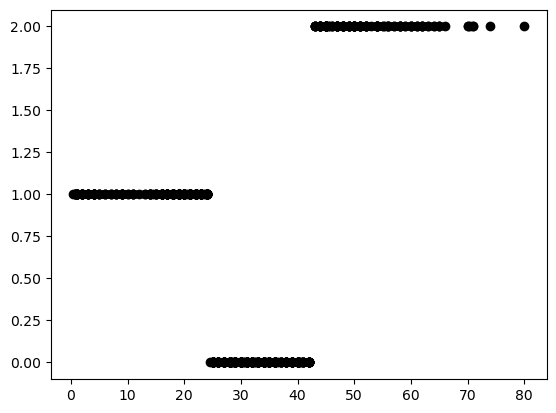

In [13]:
plt.scatter(df_2d['Age'], df_2d['Centrum'], color = 'k')
plt.show()

In [14]:
df_2d.groupby('Centrum', as_index = False)['Centrum'].count()

,Centrum
0,308
1,277
2,129


## Clusteringmodel bouwen met meer dan 2 dimensies (alle kolommen uit de dataset)

### Centra berekenen

In [15]:
kmeans = KMeans(n_clusters = 6, random_state = 42)
prediction_results = kmeans.fit_predict(df)
prediction_results

array([1, 0, 4, 0, 0, 2, 3, 4, 1, 3, 2, 1, 0, 1, 2, 3, 4, 0, 0, 1, 4, 3,
       0, 1, 0, 2, 4, 5, 1, 1, 1, 0, 4, 3, 1, 1, 3, 1, 5, 4, 2, 1, 4, 3,
       3, 1, 0, 5, 3, 4, 1, 1, 4, 4, 1, 1, 4, 4, 4, 3, 4, 1, 4, 4, 1, 0,
       1, 1, 1, 4, 1, 5, 4, 2, 2, 1, 0, 0, 4, 1, 0, 0, 4, 1, 0, 5, 1, 1,
       1, 1, 1, 2, 4, 1, 3, 1, 0, 0, 2, 3, 1, 5, 0, 1, 5, 4, 4, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 4, 3, 0, 5, 5, 1, 2, 0, 5, 1, 4, 5, 0, 4, 1,
       3, 3, 5, 4, 2, 3, 3, 1, 2, 1, 5, 4, 0, 3, 3, 3, 5, 0, 0, 4, 1, 1,
       3, 5, 2, 5, 1, 4, 0, 5, 1, 3, 4, 4, 1, 0, 1, 0, 1, 4, 4, 4, 5, 4,
       4, 1, 4, 5, 0, 1, 1, 1, 1, 0, 4, 2, 3, 1, 5, 3, 1, 0, 4, 1, 4, 5,
       4, 1, 0, 2, 4, 2, 4, 0, 4, 4, 0, 5, 3, 5, 0, 0, 1, 4, 2, 0, 4, 0,
       0, 2, 5, 3, 0, 2, 4, 1, 1, 0, 4, 1, 5, 1, 4, 1, 0, 1, 1, 1, 3, 5,
       1, 3, 1, 4, 4, 1, 1, 4, 4, 5, 4, 1, 2, 4, 0, 1, 4, 4, 1, 0, 2, 0,
       4, 1, 5, 0, 1, 4, 0, 5, 5, 3, 1, 4, 4, 0, 1, 0, 3, 5, 1, 1, 4, 4,
       1, 0, 0, 4, 5, 0, 4, 2, 1, 4, 1, 1, 1, 3, 1,

In [ ]:
kmeans_centra = pd.DataFrame(kmeans.cluster_centers_)

#Interclusterafstanden weergeven.
#Intraclusterafstanden: zelf ChatGPT'en
dists = euclidean_distances(kmeans.cluster_centers_)
pd.DataFrame(dists)

,0,1,2,3,4,5
0,0.000000,16.595261,24.215718,31.740794,8.059492,10.200162
1,16.595261,0.000000,40.810234,15.147474,8.539191,26.794845
2,24.215718,40.810234,0.000000,55.956347,32.272909,14.015704
3,31.740794,15.147474,55.956347,0.000000,23.684998,41.940740
4,8.059492,8.539191,32.272909,23.684998,0.000000,18.258078
5,10.200162,26.794845,14.015704,41.940740,18.258078,0.000000


In [18]:
df['Centrum'] = prediction_results
df

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Age,Survived,Centrum
0,False,False,True,False,True,22.0,0,1
1,True,False,False,True,False,38.0,1,0
2,False,False,True,True,False,26.0,1,4
3,True,False,False,True,False,35.0,1,0
4,False,False,True,False,True,35.0,0,0
...,...,...,...,...,...,...,...,...
885,False,False,True,True,False,39.0,0,0
886,False,True,False,False,True,27.0,0,4
887,True,False,False,True,False,19.0,1,1
889,True,False,False,False,True,26.0,1,4


### De juiste centra toewijzen aan rijen uit de dataset

In [20]:
df.groupby('Centrum', as_index = False)['Centrum'].count()

,Centrum
0,126
1,208
2,50
3,69
4,169
5,92


In [21]:
prediction_results.inte

AttributeError: 'numpy.ndarray' object has no attribute 'inte'